# Data Science Exam

## Fully Connected Feed-forward Neural Network

## Import modules and libraries

In [0]:
import io
import itertools
import keras
import numpy as np
import os
import pandas as pd
import random
import sklearn
import tensorflow as tf 

from google.colab import files
from pandas import DataFrame
from matplotlib import pyplot as plt
%matplotlib inline
from keras import backend as K
from keras import initializers
from keras.constraints import maxnorm
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


Using TensorFlow backend.


## Import Data

In [0]:
uploaded = files.upload()


Saving data.csv to data (1).csv


## Create df and plot diagnosis to check if data is balanced

B    357
M    212
Name: diagnosis, dtype: int64

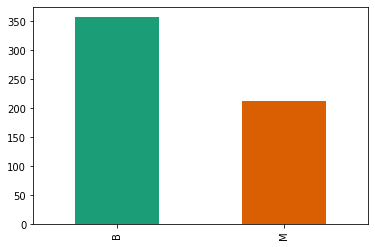

In [0]:
# Create data frame
df = pd.read_csv(io.BytesIO(uploaded['data.csv']))

# Plot diagnosis
df_diagnosis = df["diagnosis"]
df_diagnosis.value_counts().plot(kind='bar', color=plt.cm.Dark2(np.arange(len(df))))
df['diagnosis'].value_counts()


## Prepare the data set

In [0]:
# Create a data set called input_Data which include all columns of the original data set except ID, diagnosis and Unnamed: 32 which only consists of NaN
input_Data = df.drop(columns=['id','diagnosis','Unnamed: 32']) 

# We also create a data set called result_Data including the diagnosis column coded as 0 for malignant and 1 for benign
result_Data = df['diagnosis'].map({'M':0,'B':1})

# We use the sklearn's model_selection module (the function train_test_ split()) to divide the data in 70% training, 15% validation and 15% test
train_data, test_data_all, train_label, test_label_all = train_test_split(input_Data, result_Data, test_size=0.30)
val_data, test_data, val_label, test_label = train_test_split(test_data_all, test_label_all, test_size=0.50)

# Standardize the data to z-scores in order to improve accuracy, ensure faster training and meet assumptions of later optimization functions (e.g. regularization)
# We use the sklearn preprocessing module (the function StandardScaler)
scaler = StandardScaler(copy=True, with_mean=True, with_std=True) # with_mean does centering, with_std does scaling
train_data_n = scaler.fit_transform(train_data)
val_data_n = scaler.fit_transform(val_data)
test_data_n = scaler.fit_transform(test_data)

# Concatenate train and val for grid search which automatically do cross validation
train_val_data_n = np.concatenate((train_data_n, val_data_n),axis = 0)
train_val_label = train_label.append(val_label)


# The model

86/86 [==============================] - 0s 124us/step
[0.28091998710188754, 0.9069767594337463]
86/86 [==============================] - 0s 92us/step
[0.3129381468129713, 0.9069767594337463]
86/86 [==============================] - 0s 113us/step
[0.24865107342254283, 0.930232584476471]
86/86 [==============================] - 0s 104us/step
[0.22029963066411573, 0.930232584476471]
86/86 [==============================] - 0s 106us/step
[0.2634014861528264, 0.9186046719551086]
86/86 [==============================] - 0s 109us/step
[0.2522639555986537, 0.9418604373931885]
86/86 [==============================] - 0s 107us/step
[0.2557751674984777, 0.9186046719551086]
86/86 [==============================] - 0s 94us/step
[0.27776934171831885, 0.9069767594337463]
86/86 [==============================] - 0s 47us/step
[0.28208643198013306, 0.930232584476471]
86/86 [==============================] - 0s 82us/step
[0.2481373714846234, 0.9069767594337463]
86/86 [==============================] - 0

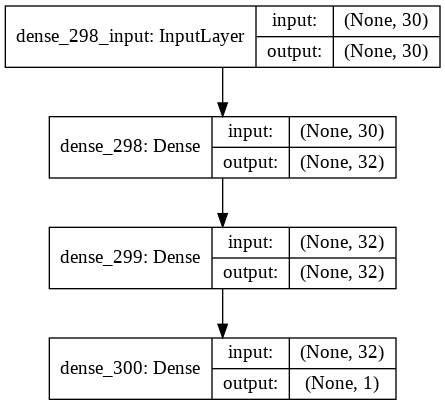

In [0]:
scores = []

for i in range(100):
  batch_size = 32
  epochs = 10

  # Input dimensions for the first layer layer
  input_dim = len(train_data.axes[1])

  # Initiate the model 
  model = Sequential()
  model.add(Dense(32, activation='relu', input_shape=(input_dim,))) # dense input layer with 32 output nodes from the layer, relu activation and 30 input nodes
  model.add(Dense(32,activation="relu"))
  model.add(Dense(1,activation="sigmoid"))

  # Use SGD as optimizer as and binary cross-entropy as loss function (because our output or prediction have only two values 0 & 1)
  model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy']
  )


  # Fit the model to train data and test it on validation data
  model.fit(train_data_n, train_label,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(val_data_n, val_label))
  score = model.evaluate(test_data_n, test_label, verbose=1)

  print(score)
  scores.append(score)

# Plot model structure
plot_model(model, to_file='model_plot.png',show_shapes=True,show_layer_names=True)



In [0]:
# Print accuracies and losses
accuracies = []
for i in range(len(scores)):
  accuracies.append(scores[i][1])

losses = []
for i in range(len(scores)):
  losses.append(scores[i][0])

print("mean accuracy: " + str(np.mean(accuracies)))
print("SD accuracy: " + str(np.std(accuracies)))
print("mean loss: " + str(np.mean(losses)))
print("SD loss: " + str(np.std(losses)))


mean accuracy: 0.9212790769338608
SD accuracy: 0.024047842473446275
mean loss: 0.2793461595129135
SD loss: 0.0404688073009442


## Confusion matrix

Confusion matrix, without normalization
[[34  4]
 [ 0 47]]


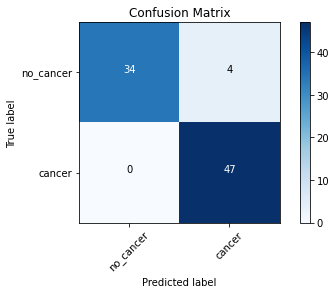

In [0]:
# Get predictions from model on validation data
rounded_predictions = model.predict_classes(x=val_data_n, batch_size=10, verbose=0)

# Create confusion matrix
cm = confusion_matrix(y_true=val_label, y_pred=rounded_predictions)

# Define plot function
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function is from https://deeplizard.com/learn/video/km7pxKy4UHU. 
    It prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['no_cancer','cancer']

# Plot confusion matrix
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Grid Search for best mini batch size and epochs

In [0]:
# Function to create model
def create_model():
	"""
  This function is from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/.
  It creates and compiles a Keras model to grid search mini batch size and epochs.
  """
	# Create model
	model = Sequential()
	model.add(Dense(32, activation='relu', input_shape=(input_dim,)))
	model.add(Dense(32,activation="relu"))
	model.add(Dense(1,activation="sigmoid"))
	
	# Compile model
	model.compile(
  optimizer='SGD', 
	loss='binary_crossentropy', 
	metrics=['accuracy']
	)
	return model

# Create model
model = KerasClassifier(build_fn=create_model, verbose=1)

# Define the grid search parameters
batch_size = [5, 10, 30, 50, 60, 75]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_val_data_n, train_val_label)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Epoch 1/50
483/483 [==============================] - 0s 338us/step - loss: 0.5161 - accuracy: 0.7950
Epoch 2/50
483/483 [==============================] - 0s 207us/step - loss: 0.2747 - accuracy: 0.9275
Epoch 3/50
483/483 [==============================] - 0s 206us/step - loss: 0.1914 - accuracy: 0.9482
Epoch 4/50
483/483 [==============================] - 0s 214us/step - loss: 0.1528 - accuracy: 0.9524
Epoch 5/50
483/483 [==============================] - 0s 210us/step - loss: 0.1306 - accuracy: 0.9586
Epoch 6/50
483/483 [==============================] - 0s 231us/step - loss: 0.1156 - accuracy: 0.9627
Epoch 7/50
483/483 [==============================] - 0s 215us/step - loss: 0.1048 - accuracy: 0.9648
Epoch 8/50
483/483 [==============================] - 0s 212us/step - loss: 0.0967 - accuracy: 0.9648
Epoch 9/50
483/483 [==============================] - 0s 217us/step - loss: 0.0903 - accuracy: 0.9752
Epoch 10/50
483/483 [==============================] - 0s 208us/step - loss: 0.085

## Grid search for momentum and learning rate

In [0]:
# Function to create model
def create_model(learn_rate=0.01, momentum=0):
	"""
  This function is from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/.
  It creates and compiles a Keras model to grid search momentum and learning rate
  """
  # Create model
	model = Sequential()
	model.add(Dense(32, activation='relu', input_shape=(input_dim,)))
	model.add(Dense(32,activation="relu"))
	model.add(Dense(1,activation="sigmoid"))
	
	# Compile model
	model.compile(
  optimizer = SGD(lr=learn_rate, momentum=momentum), 
	loss='binary_crossentropy', 
	metrics=['accuracy']
	)
	return model

# Create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=1)

# Define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_val_data_n, train_val_label)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Weight initialization

In [0]:
# Function to create model
def create_model(init_mode='uniform'):
	"""
  This function is from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/.
  It creates and compiles a Keras model to grid search weight initialization
  """
  # Create model
	model = Sequential()
	model.add(Dense(32, activation='relu', kernel_initializer=init_mode, input_shape=(input_dim,)))
	model.add(Dense(32,activation='relu',kernel_initializer=init_mode))
	model.add(Dense(1,activation="sigmoid",kernel_initializer=init_mode))
	
	# Compile model
	model.compile(
  optimizer = SGD(lr=0.2, momentum=0.4), 
	loss='binary_crossentropy', 
	metrics=['accuracy']
	)
	return model

# Create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=1)

# Define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_val_data_n, train_val_label)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Grid search for best neuron activation function (hidden layer)

In [0]:
# Function to create model
def create_model(activation='relu'):
	"""
  This function is from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/.
  It creates and compiles a Keras model to grid search activation functions.
  """
  # Create model
	model = Sequential()
	model.add(Dense(32, activation=activation, input_shape=(input_dim,), kernel_initializer='he_normal'))
	model.add(Dense(32,activation=activation, kernel_initializer = 'he_normal'))
	model.add(Dense(1,kernel_initializer = 'he_normal',activation="sigmoid"))
	
	# Compile model
	model.compile(
  optimizer = SGD(lr=0.2, momentum=0.4), 
	loss='binary_crossentropy', 
	metrics=['accuracy']
	)
	return model

# Create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=1)

# Define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_val_data_n, train_val_label)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Grid search to tune dropout regularization

In [0]:
# Function to create model
def create_model(dropout_rate=0.0, weight_constraint=0):
	"""
  This function is from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/.
  It creates and compiles a Keras model to grid search dropout regularization
  """

  # Create model
	model = Sequential()
	model.add(Dense(32, activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(weight_constraint),input_shape=(input_dim,)))
	model.add(Dense(32,activation='relu', kernel_initializer = 'he_normal', kernel_constraint=maxnorm(weight_constraint)))
	model.add(Dropout(dropout_rate))
	model.add(Dense(1,kernel_initializer='he_normal',activation="sigmoid",kernel_constraint=maxnorm(weight_constraint)))
	
	# Compile model
	model.compile(
  optimizer = SGD(lr=0.2, momentum=0.4), 
	loss='binary_crossentropy', 
	metrics=['accuracy']
	)
	return model


# Create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# Define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_val_data_n, train_val_label)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## L1 regularization



In [0]:
# Function to create model
def create_model(reg_factor=0.01):
  """
  This function is from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/.    
  It creates and compiles a Keras model to grid search L1 regularization rates
  """
  model = Sequential()
  model.add(Dense(32, activation='relu', input_shape=(input_dim,),kernel_initializer='he_normal',kernel_constraint=maxnorm(3), kernel_regularizer=l1(reg_factor)))
  model.add(Dense(32,activation="relu",kernel_initializer='he_normal',kernel_constraint=maxnorm(3),kernel_regularizer=l1(reg_factor)))
  model.add(Dropout(0.1))
  model.add(Dense(1,activation="sigmoid",kernel_initializer='he_normal',kernel_constraint=maxnorm(3),kernel_regularizer=l1(reg_factor)))
	
# Compile model
  model.compile(
      optimizer = SGD(lr=0.2, momentum=0.4), 
      loss='binary_crossentropy', 
      metrics=['accuracy']
      )
  return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=1)

# define the grid search parameters
reg_factor = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(reg_factor=reg_factor)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_val_data_n, train_val_label)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## L2 regularization

In [0]:
# Function to create model
def create_model(reg_factor=0.01):
  """
  This function is from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/.
  It creates and compiles a Keras model to grid search L2 regularization rates
  """
  model = Sequential()
  model.add(Dense(32, activation='relu', input_shape=(input_dim,),kernel_initializer='he_normal',kernel_constraint=maxnorm(3), kernel_regularizer=l2(reg_factor)))
  model.add(Dense(32,activation="relu",kernel_initializer='he_normal',kernel_constraint=maxnorm(3),kernel_regularizer=l2(reg_factor)))
  model.add(Dropout(0.1))
  model.add(Dense(1,activation="sigmoid",kernel_initializer='he_normal',kernel_constraint=maxnorm(3),kernel_regularizer=l2(reg_factor)))
	
# Compile model
  model.compile(
      optimizer = SGD(lr=0.2, momentum=0.4), 
      loss='binary_crossentropy', 
      metrics=['accuracy']
      )
  return model

# Create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=1)

# Define the grid search parameters
reg_factor = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(reg_factor=reg_factor)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_val_data_n, train_val_label)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## Gridsearch for number of neurons in the hidden layers

In [0]:
# Function to create model
def create_model(neurons=1):
	"""
  This function is from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/.
  It creates and compiles a Keras model to grid search number of neurons in the hidden layers
  """

  # Create model
	model = Sequential()
	model.add(Dense(neurons, activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(3),input_shape=(input_dim,)))
	model.add(Dense(neurons,activation="relu", kernel_initializer = 'he_normal',kernel_constraint=maxnorm(3)))
	model.add(Dropout(0.1))
	model.add(Dense(1,kernel_initializer='he_normal',activation="sigmoid",kernel_constraint=maxnorm(3)))
	
	# Compile model
	model.compile(
  optimizer = SGD(lr=0.2, momentum=0.4), 
	loss='binary_crossentropy', 
	metrics=['accuracy']
	)
	return model

# Create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# Define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30, 32, 128]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_val_data_n, train_val_label)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

##Grid search for best optimization algortihm

In [0]:
# Function to create model
def create_model(optimizer='adam'):
	"""
  This function is from https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/.
  It creates and compiles a Keras model to grid search optimization algorithm
  """

	# Create model
	model = Sequential()
	model.add(Dense(30, activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(3),input_shape=(input_dim,)))
	model.add(Dense(30,activation="relu", kernel_initializer = 'he_normal',kernel_constraint=maxnorm(3)))
	model.add(Dropout(0.1))
	model.add(Dense(1,kernel_initializer='he_normal',kernel_constraint=maxnorm(3),activation="sigmoid"))
	
	# Compile model
	model.compile(
  optimizer = optimizer, 
	loss='binary_crossentropy', 
	metrics=['accuracy']
	)
	return model

# Create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=1)

# Define the grid search parameters
optimizer = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam',SGD(learning_rate=0.2,momentum = 0.4)]
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_val_data_n, train_val_label)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


## Add extra dense layer

In [0]:
batch_size = 10
epochs = 100

# Initiate the model 
model = Sequential()
model.add(Dense(30, activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(3),input_shape=(input_dim,)))
model.add(Dense(30,activation="relu", kernel_initializer = 'he_normal',kernel_constraint=maxnorm(3))) # Extra layer
model.add(Dense(30,activation="relu", kernel_initializer = 'he_normal',kernel_constraint=maxnorm(3)))
model.add(Dropout(0.1))
model.add(Dense(1,kernel_initializer='glorot_uniform',kernel_constraint=maxnorm(3),activation="sigmoid"))

model.compile(
optimizer = 'adamax', 
loss='binary_crossentropy', 
metrics=['accuracy']
)

model.summary()

# Fit the model
model.fit(train_data_n, train_label,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(val_data_n, val_label),
          #callbacks = [plot_losses])

score = model.evaluate(val_data_n, val_label, verbose=1)

print(score)


## Add extra dropout layer

In [0]:
batch_size = 10
epochs = 100

# Initiate the model 
model = Sequential()
model.add(Dense(30, activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(3),input_shape=(input_dim,)))
model.add(Dropout(0.1)) # Extra dropout
model.add(Dense(30,activation="relu", kernel_initializer = 'he_normal',kernel_constraint=maxnorm(3)))
model.add(Dropout(0.1))
model.add(Dense(1,kernel_initializer='glorot_uniform',kernel_constraint=maxnorm(3),activation="sigmoid"))

model.compile(
optimizer = 'adamax', 
loss='binary_crossentropy', 
metrics=['accuracy']
)

model.summary()

# Fit the model
model.fit(train_data_n, train_label,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(val_data_n, val_label))

score = model.evaluate(val_data_n, val_label, verbose=1)

print(score)


## Final model

30
86/86 [==============================] - 0s 62us/step
[0.12449005107546962, 0.9767441749572754]
86/86 [==============================] - 0s 81us/step
[0.1583005480988081, 0.9651162624359131]
86/86 [==============================] - 0s 34us/step
[0.1697741622148558, 0.9651162624359131]
86/86 [==============================] - 0s 39us/step
[0.1913691107616868, 0.9651162624359131]
86/86 [==============================] - 0s 68us/step
[0.1962908520254978, 0.9767441749572754]
86/86 [==============================] - 0s 47us/step
[0.16532668575297954, 0.9651162624359131]
86/86 [==============================] - 0s 70us/step
[0.15286981297093769, 0.9767441749572754]
86/86 [==============================] - 0s 36us/step
[0.17127164990402932, 0.9767441749572754]
86/86 [==============================] - 0s 36us/step
[0.13920273337253306, 0.9883720874786377]
86/86 [==============================] - 0s 36us/step
[0.19037134564200112, 0.9651162624359131]
86/86 [==============================] - 

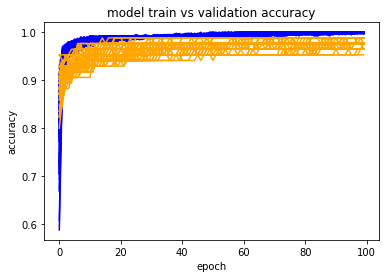

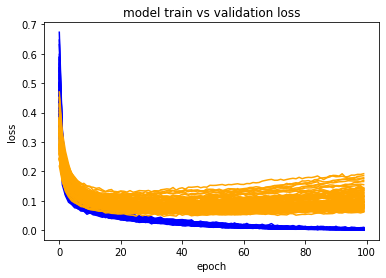

In [0]:
batch_size = 10
epochs = 100

# Input dimensions for first layer
input_dim = len(train_data.axes[1])
print(input_dim)

scores = []
train_a = DataFrame()
val_a = DataFrame()
train_l = DataFrame()
val_l = DataFrame()

for i in range(100):

  # Initiate the model 
  model = Sequential()
  model.add(Dense(30, activation='relu', input_shape=(input_dim,))) # dense input layer with 32 output nodes from the layer, relu activation and 30 input nodes
  model.add(Dense(30,activation="relu"))
  model.add(Dropout(0.1))
  model.add(Dense(1,activation="sigmoid"))

  # Using adamax as optimizer and binary_crossentropy as loss function
  model.compile(
    optimizer='adamax',
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

  # Fit the model on training data and test it on validation data
  model_fit = model.fit(train_data_n, train_label,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(val_data_n, val_label))
  score = model.evaluate(test_data_n, test_label, verbose=1)

  # store history
  train_a[str(i)] = model_fit.history['accuracy']
  val_a[str(i)] = model_fit.history['val_accuracy']
  train_l[str(i)] = model_fit.history['loss']
  val_l[str(i)] = model_fit.history['val_loss']

  print(score)
  scores.append(score)


plot_model(model, to_file='model_plot.png',show_shapes=True,show_layer_names=True)

# plot train and validation accuracy and loss across multiple runs
plt.plot(train_a, color='blue', label='train')
plt.plot(val_a, color='orange', label='validation')
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(train_l, color='blue', label='train')
plt.plot(val_l, color='orange', label='validation')
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [0]:
# Print accuracies and losses
accuracies = []
for i in range(len(scores)):
  accuracies.append(scores[i][1])

losses = []
for i in range(len(scores)):
  losses.append(scores[i][0])

print("mean accuracy: " + str(np.mean(accuracies)))
print("SD accuracy: " + str(np.std(accuracies)))
print("mean loss: " + str(np.mean(losses)))
print("SD loss: " + str(np.std(losses)))

mean accuracy: 0.9683720779418945
SD accuracy: 0.009313950671236018
mean loss: 0.16931616976727226
SD loss: 0.026292620556863815


## Run only 40 epochs

30
86/86 [==============================] - 0s 39us/step
[0.09446442612381868, 0.9767441749572754]


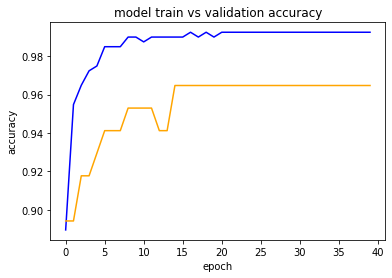

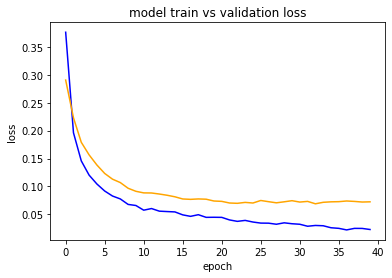

In [0]:
batch_size = 10
epochs = 40

# Input dimensions for first layer
input_dim = len(train_data.axes[1])
print(input_dim)

scores = []
train_a = DataFrame()
val_a = DataFrame()
train_l = DataFrame()
val_l = DataFrame()

for i in range(100):

  # Initiate the model 
  model = Sequential()
  model.add(Dense(30, activation='relu', input_shape=(input_dim,))) # dense input layer with 32 output nodes from the layer, relu activation and 30 input nodes
  model.add(Dense(30,activation="relu"))
  model.add(Dropout(0.1))
  model.add(Dense(1,activation="sigmoid"))

  # Using adamax as optimizer and binary_crossentropy as loss function
  model.compile(
    optimizer='adamax',
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

  # Fit the model on training data and test it on validation data
  model_fit = model.fit(train_data_n, train_label,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(val_data_n, val_label))
  score = model.evaluate(test_data_n, test_label, verbose=1)

  # store history
  train_a[str(i)] = model_fit.history['accuracy']
  val_a[str(i)] = model_fit.history['val_accuracy']
  train_l[str(i)] = model_fit.history['loss']
  val_l[str(i)] = model_fit.history['val_loss']

  print(score)
  scores.append(score)


plot_model(model, to_file='model_plot.png',show_shapes=True,show_layer_names=True)

# plot train and validation accuracy and loss across multiple runs
plt.plot(train_a, color='blue', label='train')
plt.plot(val_a, color='orange', label='validation')
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(train_l, color='blue', label='train')
plt.plot(val_l, color='orange', label='validation')
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


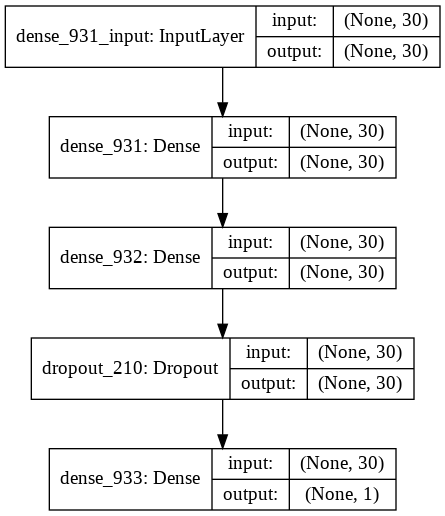

In [0]:
plot_model(model, to_file='model_plot.png',show_shapes=True,show_layer_names=True)

In [0]:
# Print accuracies and losses
accuracies = []
for i in range(len(scores)):
  accuracies.append(scores[i][1])

losses = []
for i in range(len(scores)):
  losses.append(scores[i][0])

print("mean accuracy: " + str(np.mean(accuracies)))
print("SD accuracy: " + str(np.std(accuracies)))
print("mean loss: " + str(np.mean(losses)))
print("SD loss: " + str(np.std(losses)))

mean accuracy: 0.9722092890739441
SD accuracy: 0.005905102316047433
mean loss: 0.09899687923317729
SD loss: 0.009967255238944704


Confusion matrix, without normalization
[[34  2]
 [ 0 50]]


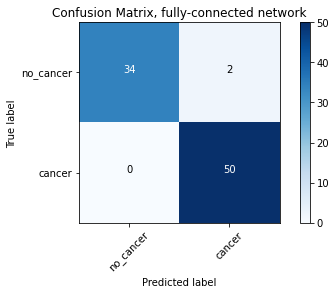

In [0]:
# Get predictions from model
rounded_predictions = model.predict_classes(x=test_data_n, batch_size=10, verbose=0)

# Create confusion matrix
cm = confusion_matrix(y_true=test_label, y_pred=rounded_predictions)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function is from https://deeplizard.com/learn/video/km7pxKy4UHU
    It prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['no_cancer','cancer']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix, fully-connected network')